# Associate ripples/spindle and Ca2+ signal 
SHORT and focus on PFC
-> in contrary to 14/14bis, here we center on SWR and not spindles and we ask whether SWR are associated with change in cortical dynamics

In [1164]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

In [1165]:
folder_base = Path('Gaelle/Baseline_recording/GreenDotsOK/session3/')

folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/minian/'

filenameE = folder_Ephys / f'SWRproperties.csv'
SWRprop = pd.read_csv(filenameE)
filenameE = folder_Ephys / f'Spindleproperties_PFC.csv'
PFCspiprop = pd.read_csv(filenameE)

filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)
filenameU = folder_Minis / f'UniTtoKeep.xlsx'
UnitToKeep = pd.read_excel(filenameU)
UnitToKeepL = UnitToKeep[0].to_list()
minian_ds = open_minian(folder_Minis)


for file_path in folder_base.glob('**/*timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)

Acq_freq = (list(stamps[0])[2])

TodropFile = folder_Minis / f'TodropFile.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)
TodropFile = folder_Minis / f'AllunitsFile.json'
with open(TodropFile, 'r') as f:
    All_units = json.load(f)

UnitToKeepLsel = []
UnitToKeepInd = [e for e, elem in enumerate(All_units) if elem in UnitToKeepL]
UnitToKeepElem = [elem for e, elem in enumerate(All_units) if elem in UnitToKeepL]
print(UnitToKeepElem)


[22, 39, 45, 64, 142]


In [1166]:
PFCspiprop[["peak time", "start time", "end time"]] = PFCspiprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
SWRprop[["peak time", "start time", "end time"]] = SWRprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
C = minian_ds['C']
A = minian_ds['A']
B = A['unit_id']

copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C = C.loc[unit_to_keep,:]
nb_unit = C.shape[0]
rec_dur = C.shape[1]


In [1167]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before


def take_closest3(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        dummy = myList.index(after)
        return dummy
    else:
        dummy = myList.index(before)
        return dummy

    

In [1168]:
Struct = "PFC"
after = 1000 # ms
counterNegSWR = 0
counterWinSWR = 0
counterUncSWR = 0
SWRinSpindle = list()
NegCoupled_SWR = list()
unCoupled_SWR = list()

serSpi = pd.Series(PFCspiprop["start time"]).to_list()
endSpi = pd.Series(PFCspiprop["end time"]).to_list()
serSWR = pd.Series(SWRprop["end time"]).to_list()
nb_SWR = SWRprop.shape[0]
nb_Spindle = PFCspiprop.shape[0]
for Pswr in range(nb_SWR-10):
    Closest_Spindle = take_closest(serSpi, serSWR[Pswr])
    index = int(take_closest3(serSpi, serSWR[Pswr]))
    if index > nb_Spindle:
        index = 0
    elif index < 0:
        index = 0
    SpinDur = endSpi[index] - serSpi[index]
    distance = serSWR[Pswr] - Closest_Spindle 
#    print(Closest_Spindle, serSWR[Pswr], distance, SpinDur, index)
    if (distance < (SpinDur)) and (distance >  0): # SWR in Spindle
        counterWinSWR = counterWinSWR + 1
        SWRinSpindle.append(Pswr)
        #print("in", serSpi[index], serSWR[Pswr], distance, SpinDur)
    elif (distance < (0)) and (distance > (-after)): # SWR preceeds Spindle
        counterNegSWR = counterNegSWR + 1
        NegCoupled_SWR.append(Pswr)
        #print("pre", serSpi[index], serSWR[Pswr], distance)
    else:
        unCoupled_SWR.append(Pswr)
        counterUncSWR = counterUncSWR + 1

print(counterNegSWR, counterWinSWR, counterUncSWR)
#print(len(PreCoupled_spindlesPFC)/nb_spindle)
#print(len(PostCoupled_spindlesPFC)/nb_spindle)

69 56 356


/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_41431/4230158217.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Activity_Per_Neurons['NegAll'][unit] = sum(AVGlocActivityCa_negSWR[0:2*Half])
/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_41431/4230158217.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Activity_Per_Neurons['NegBefore'][unit] = sum(AVGlocActivityCa_negSWR[0:Half])
/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_41431/4230158217.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

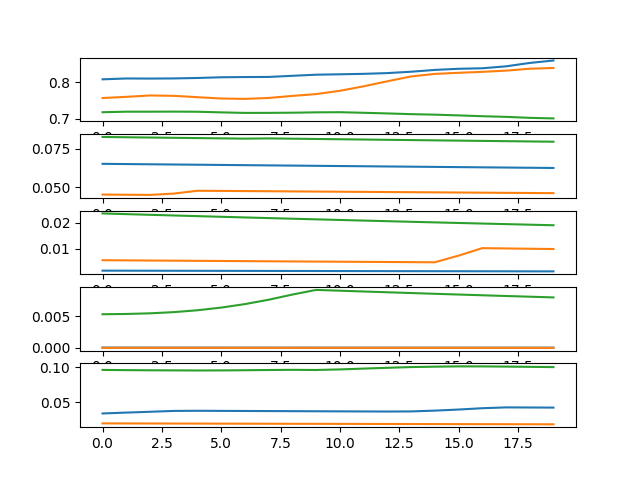

In [1169]:

#C.isel(unit_id=0).values
Cseries = C.to_series()
units = range(len(UnitToKeepInd))
maxi = len(UnitToKeepInd)
duration = 0.5
numbframes = int(duration*2*Acq_freq)
threshold = 0


data = {
    'NegAll': np.zeros(maxi),
    'NegBefore': np.zeros(maxi),
    'NegAfter' : np.zeros(maxi),
    'PosAll' : np.zeros(maxi),
    'PosBefore' : np.zeros(maxi),
    'PosAfter' : np.zeros(maxi),
    'UnAll' : np.zeros(maxi),
    'UnBefore' : np.zeros(maxi),
    'UnAfter' : np.zeros(maxi),
    'UnitId' : np.zeros(maxi)
}
Activity_Per_Neurons = pd.DataFrame(data, columns=['NegAll', 'NegBefore', 'NegAfter', 'PosAll', 'PosBefore', 'PosAfter', 'UnAll', 'UnBefore', 'UnAfter', 'UnitId'])

Activity_Per_Neurons['UnitId'] = UnitToKeepElem

ActivityCa_SWR = pd.Series(np.zeros(numbframes))
time = range(numbframes)
Half = int(ActivityCa_SWR.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()

fig, axs = plt.subplots(nrows=maxi, ncols=1)


AVGActivityCa_negSWR = pd.Series(np.zeros(numbframes))
nAVGActivityCa_negSWR = pd.Series(np.zeros(numbframes))
for unit in units:
    ActivityCa_negSWR = pd.Series(np.zeros(numbframes))
    AVGlocActivityCa_negSWR = pd.Series(np.zeros(numbframes))
    lCseries = C.isel(unit_id=unit).values
    for Pspin in NegCoupled_SWR:
        ser = pd.Series(SWRprop["start time"])
        Frame_SWR_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        index = TimeStamps_miniscope.index(Frame_SWR_start)
        trace = lCseries[index-Half:index+Half]
        if len(trace)<len(time):
            print("pre, unit = ", unit, "SWR = ", Pspin)
        else:
            ActivityCa_negSWR = ActivityCa_negSWR+list(lCseries[index-Half:index+Half])# move by half for CTRL
    if max(ActivityCa_negSWR)>(len(NegCoupled_SWR)*threshold):
        nActivityCa_negSWR = ActivityCa_negSWR/max(ActivityCa_negSWR)
    elif sum(trace)>threshold:
        nActivityCa_negSWR = 0#ActivityCa_PFCspin
    
    AVGActivityCa_negSWR = AVGActivityCa_negSWR + ActivityCa_negSWR    
    AVGlocActivityCa_negSWR = AVGlocActivityCa_negSWR + ActivityCa_negSWR    
    nAVGActivityCa_negSWR = nAVGActivityCa_negSWR + nActivityCa_negSWR 
    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_negSWR/counterNegSWR) 
    Activity_Per_Neurons['NegAll'][unit] = sum(AVGlocActivityCa_negSWR[0:2*Half])
    Activity_Per_Neurons['NegBefore'][unit] = sum(AVGlocActivityCa_negSWR[0:Half])
    Activity_Per_Neurons['NegAfter'][unit] = sum(AVGlocActivityCa_negSWR[Half:2*Half])
    
if max(AVGActivityCa_negSWR)>(threshold):
    nAVGActivityCa_negSWR = AVGActivityCa_negSWR/max(AVGActivityCa_negSWR)
else:
    nAVGActivityCa_negSWR = AVGActivityCa_negSWR


prCactBefore = sum(AVGActivityCa_negSWR[0:Half])
prCactAfter = sum(AVGActivityCa_negSWR[Half:2*Half])
nprCactBefore = sum(nAVGActivityCa_negSWR[0:Half])
nprCactAfter = sum(nAVGActivityCa_negSWR[Half:2*Half])


AVGActivityCa_winSWR = pd.Series(np.zeros(numbframes))
nAVGActivityCa_winSWR = pd.Series(np.zeros(numbframes))
for unit in units:
    AVGlocActivityCa_winSWR = pd.Series(np.zeros(numbframes))
    ActivityCa_winSWR = pd.Series(np.zeros(numbframes))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in SWRinSpindle:
        ser = pd.Series(SWRprop["start time"])
        Frame_SWR_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        index = TimeStamps_miniscope.index(Frame_SWR_start)
        trace = list(lCseries[index-Half:index+Half])
        if len(trace)<len(time):
            print("post, unit = ", unit, "SWR = ", Pspin)
        else:
            ActivityCa_winSWR = ActivityCa_winSWR+list(lCseries[index-Half:index+Half])# move by half for CTRL
    if max(ActivityCa_winSWR)>(len(SWRinSpindle)*threshold):
        nActivityCa_winSWR = ActivityCa_winSWR/max(ActivityCa_winSWR)
    elif sum(trace)>threshold:
        nActivityCa_winSWR = 0
    AVGActivityCa_winSWR = AVGActivityCa_winSWR + ActivityCa_winSWR
    AVGlocActivityCa_winSWR = AVGlocActivityCa_winSWR + ActivityCa_winSWR   
    nAVGActivityCa_winSWR = nAVGActivityCa_winSWR + nActivityCa_winSWR 
    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_winSWR/counterWinSWR) 
    Activity_Per_Neurons['PosAll'][unit] = sum(AVGlocActivityCa_winSWR[0:2*Half])
    Activity_Per_Neurons['PosBefore'][unit] = sum(AVGlocActivityCa_winSWR[0:Half])
    Activity_Per_Neurons['PosAfter'][unit] = sum(AVGlocActivityCa_winSWR[Half:2*Half])

if max(AVGActivityCa_winSWR)>(threshold):
    nAVGActivityCa_winSWR = AVGActivityCa_winSWR/max(AVGActivityCa_winSWR)
else:
    nAVGActivityCa_winSWR = AVGActivityCa_winSWR


poCactBefore = sum(AVGActivityCa_winSWR[0:Half])
poCactAfter = sum(AVGActivityCa_winSWR[Half:2*Half])
npoCactBefore = sum(nAVGActivityCa_winSWR[0:Half])
npoCactAfter = sum(nAVGActivityCa_winSWR[Half:2*Half])

AVGActivityCa_uncSWR = pd.Series(np.zeros(numbframes))
nAVGActivityCa_uncSWR = pd.Series(np.zeros(numbframes))
for unit in units:
    ActivityCa_uncSWR = pd.Series(np.zeros(numbframes))
    AVGlocActivityCa_uncSWR = pd.Series(np.zeros(numbframes))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in unCoupled_SWR:
        ser = pd.Series(SWRprop["start time"])
        Frame_SWR_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        index = TimeStamps_miniscope.index(Frame_SWR_start)
        trace = list(lCseries[index-Half:index+Half])# move by half for CTRL
        if len(trace)<len(time):
            print("post, unit = ", unit, "SWR = ", Pspin)
        elif sum(trace)>threshold:
            ActivityCa_uncSWR = ActivityCa_uncSWR+list(lCseries[index-Half:index+Half])# move by half for CTRL
    if max(ActivityCa_uncSWR)>(len(unCoupled_SWR)*threshold):
        nActivityCa_uncSWR = ActivityCa_uncSWR/max(ActivityCa_uncSWR)
    else:
        nActivityCa_uncSWR = 0#ActivityCa_PFCspin
    AVGActivityCa_uncSWR = AVGActivityCa_uncSWR + ActivityCa_uncSWR
    AVGlocActivityCa_uncSWR = AVGlocActivityCa_uncSWR + ActivityCa_uncSWR   
    nAVGActivityCa_uncSWR = nAVGActivityCa_uncSWR + nActivityCa_uncSWR 
    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_uncSWR/counterUncSWR) 
    Activity_Per_Neurons['UnAll'][unit] = sum(AVGlocActivityCa_uncSWR[0:2*Half])
    Activity_Per_Neurons['UnBefore'][unit] = sum(AVGlocActivityCa_uncSWR[0:Half])
    Activity_Per_Neurons['UnAfter'][unit] = sum(AVGlocActivityCa_uncSWR[Half:2*Half])

if max(AVGActivityCa_uncSWR)>(threshold):
    nAVGActivityCa_uncSWR = AVGActivityCa_uncSWR/max(AVGActivityCa_uncSWR)
else:
    nAVGActivityCa_uncSWR = AVGActivityCa_uncSWR

unCactBefore = sum(AVGActivityCa_uncSWR[0:Half])
unCactAfter = sum(AVGActivityCa_uncSWR[Half:2*Half])
nunCactBefore = sum(nAVGActivityCa_uncSWR[0:Half])
nunCactAfter = sum(nAVGActivityCa_uncSWR[Half:2*Half])
#fig.savefig('mafigure.svg')
#plt.plot(time, AVGActivityCa_negSWR/counterNegSWR, label='NegCoupling')  
#plt.plot(time, AVGActivityCa_winSWR/counterWinSWR, label='SWRinSpindle')  
#plt.plot(time, AVGActivityCa_uncSWR/counterUncSWR, label='UnCoup')

#plt.legend();
#plt.show()

In [1170]:
negCoupledBef = prCactBefore
negCoupledAft = prCactAfter
nnegCoupledBef = nprCactBefore
nnegCoupledAft = nprCactAfter

posCoupledBef = poCactBefore
posCoupledAft = poCactAfter
nposCoupledBef = npoCactBefore
nposCoupledAft = npoCactAfter

unCoupledBef = unCactBefore
unCoupledAft = unCactAfter
nunCoupledBef = nunCactBefore
nunCoupledAft = nunCactAfter

outSumm = pd.Series([negCoupledBef, negCoupledAft, posCoupledBef, posCoupledAft, unCoupledBef, unCoupledAft, nnegCoupledBef, nnegCoupledAft, nposCoupledBef, nposCoupledAft, nunCoupledBef, nunCoupledAft],
              index=["NCB", "NCA", "wSCB", "wSCA", "1CB", "1CA", "nNCB", "nNCA", "nwSCB", "nwSCA", "n1CB", "n1CA"])

#filenameOut = folder_base / f'CTRL_SpikesSWRspindles_16bis.xlsx'
#writer = pd.ExcelWriter(filenameOut)
#outSumm.to_excel(writer)
#writer.save()
outSumm

NCB       631.744417
NCA       648.379081
wSCB      465.559382
wSCA      497.916074
1CB      3293.672045
1CA      3271.991277
nNCB        9.487960
nNCA        9.737791
nwSCB       9.104439
nwSCA       9.737204
n1CB        9.982088
n1CA        9.916381
dtype: float64

In [1171]:

filenameOut = folder_base / f'Spikes_SWRspindlesInd500ms_16bis.xlsx'
writer = pd.ExcelWriter(filenameOut)
Activity_Per_Neurons.to_excel(writer)
writer.save()
Activity_Per_Neurons

,NegAll,NegBefore,NegAfter,PosAll,PosBefore,PosAfter,UnAll,UnBefore,UnAfter,UnitId
0,1137.483711,560.787300,576.696411,882.801780,425.569602,457.232178,5084.924604,2556.888629,2528.035975,22
1,88.010533,44.491243,43.519290,52.155900,26.070601,26.085299,577.078276,291.319894,285.758383,39
2,1.774178,0.937368,0.836809,6.911771,2.922651,3.989121,151.605637,80.099268,71.506369,45
3,0.063939,0.034181,0.029757,0.020112,0.010752,0.009360,53.679921,23.516486,30.163434,64
4,52.791137,25.494325,27.296813,21.585893,10.985777,10.600116,698.374884,341.847767,356.527117,142


In [1172]:
outCount = pd.Series([counterNegSWR, counterWinSWR, counterUncSWR],
              index=["NegSWR", "WinSWR", "uncSWR"])


#filenameOut = folder_base / f'CounterSWR_16bis.xlsx'
#writer = pd.ExcelWriter(filenameOut)
#outCount.to_excel(writer)
#writer.save()
